In [1]:
#    🎯 Test Loss: 0.4181 | Test Accuracy: 0.8594

#      Epoch 09 | Test Loss: 0.2703 | Test Accuracy: 0.9136
#      Epoch 02 | Test Loss: 0.2242 | Test Accuracy: 0.9122

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

# —— 1. 忽略隐藏目录 —— #
class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and not d.name.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        return classes, class_to_idx

# —— 2. 配置 —— #
train_dir     = "/root/autodl-fs/processed/processed/train"
val_dir       = "/root/autodl-fs/processed/processed/val"     # 可选，如果无验证集，可以 split 训练集
test_dir      = "/root/autodl-fs/processed/processed/test"
ckpt_path     = "/root/autodl-fs/best_resnet50.pth"
batch_size    = 32
num_epochs    = 10
learning_rate = 1e-4
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# —— 3. 预处理 —— #
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# —— 4. 加载数据 —— #
train_dataset = FilteredImageFolder(root=train_dir, transform=train_transform)
test_dataset  = FilteredImageFolder(root=test_dir,  transform=eval_transform)

# 如有 val 目录就用，否则从 train_dataset 划分一部分
if os.path.exists(val_dir):
    val_dataset = FilteredImageFolder(root=val_dir, transform=eval_transform)
else:
    val_len = int(len(train_dataset) * 0.15)
    train_len = len(train_dataset) - val_len
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

# —— 5. 模型定义 —— #
model = models.resnet50(pretrained=True)
num_classes = len(train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# —— 6. 训练 + 验证 + 保存最佳模型 —— #
best_val_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = 0.0, 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_acc += (out.argmax(1) == y).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_acc  /= len(train_loader.dataset)

    # 验证
    model.eval()
    val_loss, val_acc = 0.0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_acc  += (out.argmax(1) == y).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc  /= len(val_loader.dataset)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
        torch.save(model.state_dict(), ckpt_path)
        print("✅ Saved Best Model!")

# —— 7. 加载并评估测试集 —— #
model.load_state_dict(torch.load(ckpt_path))
model.eval()
test_loss, test_acc, total = 0.0, 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item() * x.size(0)
        test_acc  += (out.argmax(1) == y).sum().item()
        total += y.size(0)

test_loss /= total
test_acc  /= total
print(f"🎯 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Epoch 1/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 0.2482, Acc: 0.9013 | Val Loss: 0.1992, Acc: 0.9251
✅ Saved Best Model!


Epoch 2/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 0.1880, Acc: 0.9288 | Val Loss: 0.2180, Acc: 0.9307
✅ Saved Best Model!


Epoch 3/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 0.1547, Acc: 0.9411 | Val Loss: 0.1945, Acc: 0.9294


Epoch 4/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 0.1308, Acc: 0.9495 | Val Loss: 0.2469, Acc: 0.9201


Epoch 5/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 0.1138, Acc: 0.9565 | Val Loss: 0.2145, Acc: 0.9325
✅ Saved Best Model!


Epoch 6/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 0.0914, Acc: 0.9677 | Val Loss: 0.2317, Acc: 0.9214


Epoch 7/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 0.0868, Acc: 0.9691 | Val Loss: 0.3160, Acc: 0.9077


Epoch 8/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 8] Train Loss: 0.0594, Acc: 0.9772 | Val Loss: 0.3425, Acc: 0.9189


Epoch 9/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 9] Train Loss: 0.0582, Acc: 0.9783 | Val Loss: 0.3562, Acc: 0.9313


Epoch 10/10:   0%|          | 0/287 [00:00<?, ?it/s]

[Epoch 10] Train Loss: 0.0446, Acc: 0.9825 | Val Loss: 0.3567, Acc: 0.9195


/tmp/ipykernel_24510/918187836.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path))


🎯 Test Loss: 0.4181 | Test Accuracy: 0.8594


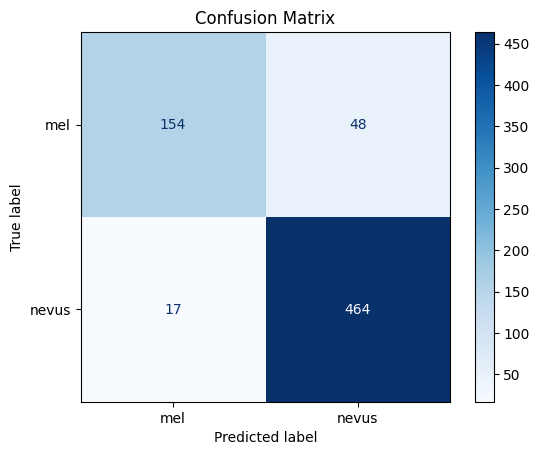

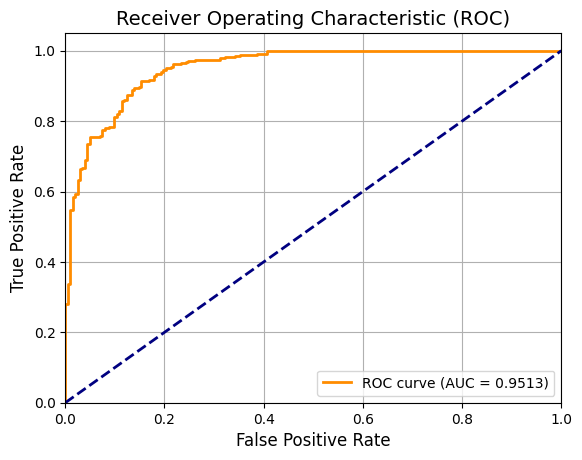

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

# 确保模型在评估模式
model.eval()

# 收集所有测试标签和预测概率
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        probs = torch.softmax(out, dim=1)[:, 1]  # 只取 positive 类的概率
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.numpy())

# 转换为 numpy 数组
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# —— 1. 绘制混淆矩阵 —— #
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.dataset.classes)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# —— 2. 绘制 ROC 曲线 —— #
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 随机预测基线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
#去除毛发后做分类

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

# —— 1. 忽略隐藏目录 —— #
class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and not d.name.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        return classes, class_to_idx

# —— 2. 配置 —— #
train_dir     = "/root/autodl-fs/generate/train"
val_dir       = "/root/autodl-fs/generate/val"     # 可选，如果无验证集，可以 split 训练集
test_dir      = "/root/autodl-fs/generate/test"
ckpt_path     = "/root/autodl-fs/best_resnet50.pth"
batch_size    = 32
num_epochs    = 10
learning_rate = 1e-4
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# —— 3. 预处理 —— #
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# —— 4. 加载数据 —— #
train_dataset = FilteredImageFolder(root=train_dir, transform=train_transform)
test_dataset  = FilteredImageFolder(root=test_dir,  transform=eval_transform)

# 如有 val 目录就用，否则从 train_dataset 划分一部分
if os.path.exists(val_dir):
    val_dataset = FilteredImageFolder(root=val_dir, transform=eval_transform)
else:
    val_len = int(len(train_dataset) * 0.15)
    train_len = len(train_dataset) - val_len
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

# —— 5. 模型定义 —— #
model = models.resnet50(pretrained=True)
num_classes = len(train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# —— 6. 训练 + 验证 + 保存最佳模型 —— #
best_val_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = 0.0, 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_acc += (out.argmax(1) == y).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_acc  /= len(train_loader.dataset)

    # 验证
    model.eval()
    val_loss, val_acc = 0.0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_acc  += (out.argmax(1) == y).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc  /= len(val_loader.dataset)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
        torch.save(model.state_dict(), ckpt_path)
        print("✅ Saved Best Model!")

    # 每个 epoch 保存一次模型
    epoch_ckpt_path = f"/root/autodl-fs/ckpt/epoch_{epoch+1}.pth"
    os.makedirs(os.path.dirname(epoch_ckpt_path), exist_ok=True)
    torch.save(model.state_dict(), epoch_ckpt_path)


# —— 7. 加载并评估测试集 —— #
model.load_state_dict(torch.load(ckpt_path))
model.eval()
test_loss, test_acc, total = 0.0, 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item() * x.size(0)
        test_acc  += (out.argmax(1) == y).sum().item()
        total += y.size(0)

test_loss /= total
test_acc  /= total
print(f"🎯 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# —— 所有 epoch 的模型推理 —— #
print("\n📊 Evaluating all epoch checkpoints on test set:")
epoch_results = []

for e in range(1, num_epochs + 1):
    ckpt_file = f"/root/autodl-fs/ckpt/epoch_{e}.pth"
    if not os.path.exists(ckpt_file):
        print(f"❌ Epoch {e} model not found.")
        continue

    model.load_state_dict(torch.load(ckpt_file))
    model.eval()

    test_loss, test_acc, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            test_loss += loss.item() * x.size(0)
            test_acc  += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    test_loss /= total
    test_acc  /= total
    epoch_results.append((e, test_loss, test_acc))
    print(f"📁 Epoch {e:02d} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 0.2608, Acc: 0.8963 | Val Loss: 0.2530, Acc: 0.9090
✅ Saved Best Model!


Epoch 2/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 0.1921, Acc: 0.9253 | Val Loss: 0.2209, Acc: 0.9152
✅ Saved Best Model!


Epoch 3/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 0.1563, Acc: 0.9376 | Val Loss: 0.2603, Acc: 0.8898


Epoch 4/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 0.1420, Acc: 0.9479 | Val Loss: 0.1937, Acc: 0.9195
✅ Saved Best Model!


Epoch 5/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 0.1160, Acc: 0.9576 | Val Loss: 0.2045, Acc: 0.9115


Epoch 6/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 0.0915, Acc: 0.9677 | Val Loss: 0.2626, Acc: 0.9065


Epoch 7/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 0.0760, Acc: 0.9740 | Val Loss: 0.2829, Acc: 0.9003


Epoch 8/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 8] Train Loss: 0.0750, Acc: 0.9742 | Val Loss: 0.2713, Acc: 0.9015


Epoch 9/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 9] Train Loss: 0.0480, Acc: 0.9839 | Val Loss: 0.2695, Acc: 0.9053


Epoch 10/10:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 10] Train Loss: 0.0390, Acc: 0.9865 | Val Loss: 0.4761, Acc: 0.8830


/tmp/ipykernel_1331/1069792829.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path))


🎯 Test Loss: 0.2590 | Test Accuracy: 0.8960

📊 Evaluating all epoch checkpoints on test set:


/tmp/ipykernel_1331/1069792829.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_file))


📁 Epoch 01 | Test Loss: 0.3570 | Test Accuracy: 0.8594
📁 Epoch 02 | Test Loss: 0.2822 | Test Accuracy: 0.8755
📁 Epoch 03 | Test Loss: 0.2700 | Test Accuracy: 0.8843
📁 Epoch 04 | Test Loss: 0.2590 | Test Accuracy: 0.8960
📁 Epoch 05 | Test Loss: 0.2445 | Test Accuracy: 0.9004
📁 Epoch 06 | Test Loss: 0.2954 | Test Accuracy: 0.8917
📁 Epoch 07 | Test Loss: 0.3238 | Test Accuracy: 0.8902
📁 Epoch 08 | Test Loss: 0.3431 | Test Accuracy: 0.8799
📁 Epoch 09 | Test Loss: 0.3405 | Test Accuracy: 0.8755
📁 Epoch 10 | Test Loss: 0.5521 | Test Accuracy: 0.8653


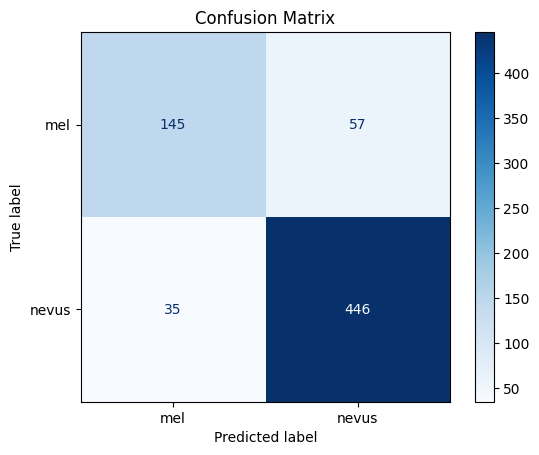

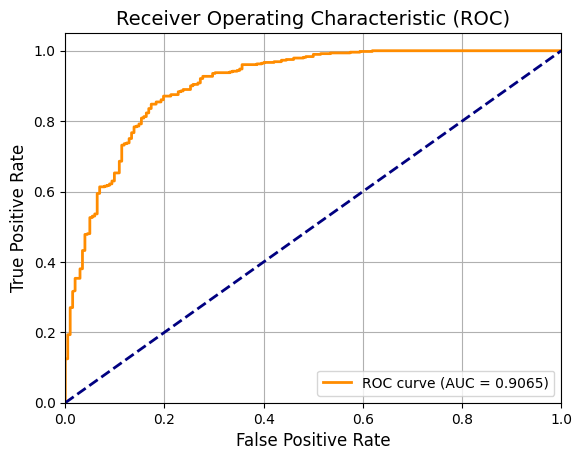

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

# 确保模型在评估模式
model.eval()

# 收集所有测试标签和预测概率
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        probs = torch.softmax(out, dim=1)[:, 1]  # 只取 positive 类的概率
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.numpy())

# 转换为 numpy 数组
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# —— 1. 绘制混淆矩阵 —— #
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.dataset.classes)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# —— 2. 绘制 ROC 曲线 —— #
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 随机预测基线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

# —— 1. 忽略隐藏目录 —— #
class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and not d.name.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        return classes, class_to_idx

# —— 2. 配置 —— #
train_dir     = "/root/autodl-fs/generate/train"
val_dir       = "/root/autodl-fs/generate/val"     # 可选，如果无验证集，可以 split 训练集
test_dir      = "/root/autodl-fs/generate/test"
ckpt_path     = "/root/autodl-fs/best_resnet50.pth"
batch_size    = 32
num_epochs    = 15
learning_rate = 1e-4
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# —— 3. 预处理 —— #
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# —— 4. 加载数据 —— #
train_dataset = FilteredImageFolder(root=train_dir, transform=train_transform)
test_dataset  = FilteredImageFolder(root=test_dir,  transform=eval_transform)

# 如有 val 目录就用，否则从 train_dataset 划分一部分
if os.path.exists(val_dir):
    val_dataset = FilteredImageFolder(root=val_dir, transform=eval_transform)
else:
    val_len = int(len(train_dataset) * 0.15)
    train_len = len(train_dataset) - val_len
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

# —— 5. 模型定义 —— #
model = models.resnet50(pretrained=True)
num_classes = len(train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# —— 6. 训练 + 验证 + 保存最佳模型 —— #
best_val_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = 0.0, 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_acc += (out.argmax(1) == y).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_acc  /= len(train_loader.dataset)

    # 验证
    model.eval()
    val_loss, val_acc = 0.0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_acc  += (out.argmax(1) == y).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc  /= len(val_loader.dataset)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
        torch.save(model.state_dict(), ckpt_path)
        print("✅ Saved Best Model!")

    # 每个 epoch 保存一次模型
    epoch_ckpt_path = f"/root/autodl-fs/ckpt/epoch_{epoch+1}.pth"
    os.makedirs(os.path.dirname(epoch_ckpt_path), exist_ok=True)
    torch.save(model.state_dict(), epoch_ckpt_path)


# —— 7. 加载并评估测试集 —— #
model.load_state_dict(torch.load(ckpt_path))
model.eval()
test_loss, test_acc, total = 0.0, 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item() * x.size(0)
        test_acc  += (out.argmax(1) == y).sum().item()
        total += y.size(0)

test_loss /= total
test_acc  /= total
print(f"🎯 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# —— 所有 epoch 的模型推理 —— #
print("\n📊 Evaluating all epoch checkpoints on test set:")
epoch_results = []

for e in range(1, num_epochs + 1):
    ckpt_file = f"/root/autodl-fs/ckpt/epoch_{e}.pth"
    if not os.path.exists(ckpt_file):
        print(f"❌ Epoch {e} model not found.")
        continue

    model.load_state_dict(torch.load(ckpt_file))
    model.eval()

    test_loss, test_acc, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            test_loss += loss.item() * x.size(0)
            test_acc  += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    test_loss /= total
    test_acc  /= total
    epoch_results.append((e, test_loss, test_acc))
    print(f"📁 Epoch {e:02d} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 0.2580, Acc: 0.8982 | Val Loss: 0.2015, Acc: 0.9189
✅ Saved Best Model!


Epoch 2/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 0.1980, Acc: 0.9244 | Val Loss: 0.1917, Acc: 0.9245
✅ Saved Best Model!


Epoch 3/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 0.1692, Acc: 0.9342 | Val Loss: 0.1941, Acc: 0.9313
✅ Saved Best Model!


Epoch 4/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 0.1443, Acc: 0.9435 | Val Loss: 0.1920, Acc: 0.9300


Epoch 5/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 0.1228, Acc: 0.9559 | Val Loss: 0.2263, Acc: 0.9195


Epoch 6/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 0.0974, Acc: 0.9648 | Val Loss: 0.1985, Acc: 0.9313


Epoch 7/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 0.0792, Acc: 0.9689 | Val Loss: 0.1859, Acc: 0.9313


Epoch 8/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 8] Train Loss: 0.0612, Acc: 0.9779 | Val Loss: 0.2323, Acc: 0.9288


Epoch 9/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 9] Train Loss: 0.0606, Acc: 0.9781 | Val Loss: 0.3002, Acc: 0.9232


Epoch 10/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 10] Train Loss: 0.0505, Acc: 0.9806 | Val Loss: 0.2959, Acc: 0.9276


Epoch 11/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 11] Train Loss: 0.0432, Acc: 0.9852 | Val Loss: 0.3076, Acc: 0.9220


Epoch 12/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 12] Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.2696, Acc: 0.9337
✅ Saved Best Model!


Epoch 13/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 13] Train Loss: 0.0291, Acc: 0.9893 | Val Loss: 0.2627, Acc: 0.9307


Epoch 14/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 14] Train Loss: 0.0279, Acc: 0.9905 | Val Loss: 0.2965, Acc: 0.9337


Epoch 15/15:   0%|          | 0/286 [00:00<?, ?it/s]

[Epoch 15] Train Loss: 0.0314, Acc: 0.9879 | Val Loss: 0.2511, Acc: 0.9226


/tmp/ipykernel_1405/4179968195.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path))


🎯 Test Loss: 0.4004 | Test Accuracy: 0.8990

📊 Evaluating all epoch checkpoints on test set:


/tmp/ipykernel_1405/4179968195.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_file))


📁 Epoch 01 | Test Loss: 0.2816 | Test Accuracy: 0.8902
📁 Epoch 02 | Test Loss: 0.2542 | Test Accuracy: 0.9034
📁 Epoch 03 | Test Loss: 0.2272 | Test Accuracy: 0.9107
📁 Epoch 04 | Test Loss: 0.2529 | Test Accuracy: 0.8975
📁 Epoch 05 | Test Loss: 0.3353 | Test Accuracy: 0.8755
📁 Epoch 06 | Test Loss: 0.2859 | Test Accuracy: 0.9034
📁 Epoch 07 | Test Loss: 0.2554 | Test Accuracy: 0.9122
📁 Epoch 08 | Test Loss: 0.3217 | Test Accuracy: 0.8931
📁 Epoch 09 | Test Loss: 0.3675 | Test Accuracy: 0.8917
📁 Epoch 10 | Test Loss: 0.4308 | Test Accuracy: 0.8960
📁 Epoch 11 | Test Loss: 0.3516 | Test Accuracy: 0.9165
📁 Epoch 12 | Test Loss: 0.4004 | Test Accuracy: 0.8990
📁 Epoch 13 | Test Loss: 0.3780 | Test Accuracy: 0.9078
📁 Epoch 14 | Test Loss: 0.3873 | Test Accuracy: 0.9107
📁 Epoch 15 | Test Loss: 0.3474 | Test Accuracy: 0.9048


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

# 确保模型在评估模式
model.eval()

# 收集所有测试标签和预测概率
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        probs = torch.softmax(out, dim=1)[:, 1]  # 只取 positive 类的概率
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.numpy())

# 转换为 numpy 数组
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# —— 1. 绘制混淆矩阵 —— #
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.dataset.classes)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# —— 2. 绘制 ROC 曲线 —— #
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 随机预测基线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
